In [1]:
import numpy as np
try:
    import ujson as json
except ImportError:
    import json
import tensorflow as tf
from RNN_model_GRAD import *
import matplotlib.pyplot as plt
import networkx as nx
import math
import pickle
from sklearn.decomposition import PCA
import pandas as pd
from numpy.linalg import eig

In [2]:
with open('weight_history_0.json') as f:
    weight_history = json.load(f) 
with open("loss_history_0.txt", "rb") as fp:   # Unpickling
    loss_history = pickle.load(fp)

In [3]:
noise_weights = np.array(weight_history['noise weights'])
bias_weights = np.array(weight_history['bias'])
input1_weights = np.array(weight_history['input1 weights'])
input2_weights = np.array(weight_history['input2 weights'])
output_weight_matrix = np.array(weight_history['output weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
final_weights = np.array(weight_history['trained weights'][-1])
final_weights[np.abs(final_weights)<0.01]=0
initial_weights=np.array(weight_history['trained weights'][0])

# Defining Network

In [4]:
num_nodes = 256
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = 0.01

weight_matrix = tf.Variable(final_weights)
connectivity_matrix = tf.constant(connectivity_matrix)

input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input1_weights, input2_weights)))

def input1(time):
    #No input for now
    return 0
 
def input2(time):
    #No input for now
    return 0
def bias(time):
    #return 0
    return 1
def noise(time):
    #return 0
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)

# This is a list of function.
input_funcs = [bias, noise, input1, input2]

init_activations = tf.constant(np.zeros((num_nodes, 1)))
output_weight_matrix = tf.constant(output_weight_matrix)
        
network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
             timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)

# Stimulate network without input

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1788.36it/s]


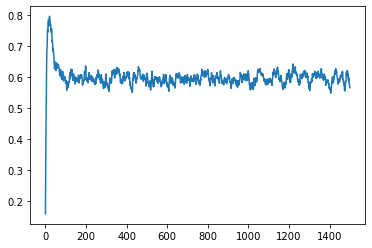

In [5]:
time = 15000 #ms
inputs = network.convert(time, input_funcs)
outputs, activations = network.simulate(time, inputs, input_weight_matrix)

outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.show()

# Testing network performance

In [6]:
network.reset_activations()
switch_time = int(np.random.normal(time/2, time/10))

vals = [0.07467629610156967,
                 0.7359636110186749,

                 0.8539031805891266,
                 0.2217757958985292,

                 1.0626550395145082,
                 1.658718091495952,

                 1.5236087579751052,
                 0.6748203691430474,

                 1.503502492405255,
                 0.5515897513164214,

                 0.7399393606650884,
                 1.9693085139963118,

                 1.5630782552283364,
                 0.16254168289490778,

                 1.16170464268611529,
                 0.43710186628152736,

                 1.0336961211169585,
                 1.611615114846882,

                 1.0401701787650914,
                 0.2431485181121429,

                 1.6216936770094201,
                 0.7940338406666316,

                 0.201048287764956,
                 1.1074806890706668,

                 1.7261748017980978,
                 0.5199807105927352,

                 0.6068925081516026,
                 1.0121364798169339,

                 1.7573508638878571,
                 1.154040710372573,

                 0.3567944504236231,
                 1.5390409894022066]

def input1(time):
               #running for 15 seconds = 15000ms
    if time < switch_time:
        return vals[i] + np.random.normal(0, .01)
    else:
        return vals[i+2] + np.random.normal(0, .01)

def input2(time):
                #running for 15 seconds = 15000ms
    if time < switch_time:
        return vals[i+1] + np.random.normal(0, .01)
    else:
        return vals[i+3] + np.random.normal(0, .01)

def target_func(time):
                #running for 15 seconds = 15000ms
    if time < switch_time:
        return 0.5 * (vals[i] > vals[i+1]) + .8 * (vals[i+1] > vals[i])
    else:
        return 0.5 * (vals[i+2] > vals[i+3]) + .8 * (vals[i+3] > vals[i+2])

## Testing the first trajectory

In [7]:
i=0
input_funcs[2] = input1
input_funcs[3] = input2
inputs = network.convert(time, input_funcs)
outputs, activations1 = network.simulate(time, inputs, input_weight_matrix)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1798.97it/s]


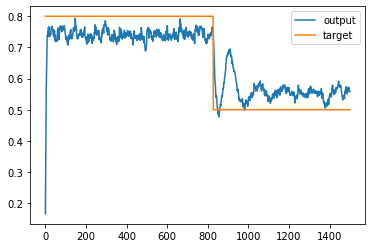

In [8]:
outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs,label='output')
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))],label='target')
plt.legend()
plt.show()

## Testing the second trajectory

In [9]:
i=4
input_funcs[2] = input1
input_funcs[3] = input2
inputs = network.convert(time, input_funcs)
outputs, activations2 = network.simulate(time, inputs, input_weight_matrix)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1849.99it/s]


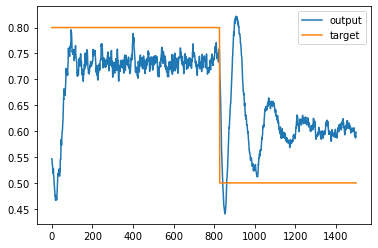

In [10]:
outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs,label='output')
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))],label='target')
plt.legend()
plt.show()

# Analyze neuron activations

In [11]:
activations = [activation.numpy() for activation in activations]
activations = np.asarray(activations)

num_nodes = 256
G = nx.complete_graph(num_nodes)
for u,v,d in G.edges(data=True):
    d['weight'] = final_weights[u,v] + final_weights[v,u]
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = nx.spring_layout(G,weight='weight', iterations=1000)

## Directly plot neuron activations

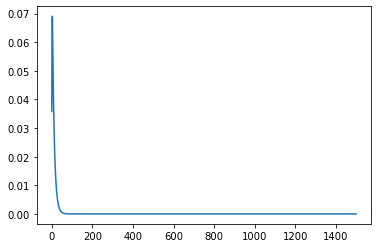

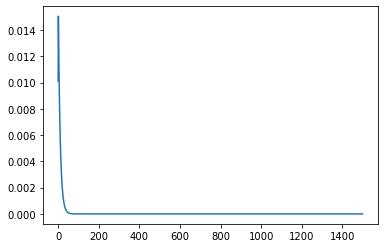

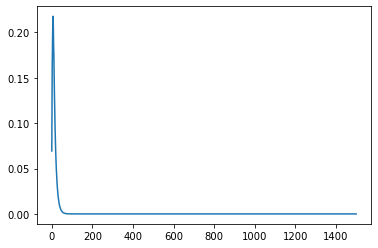

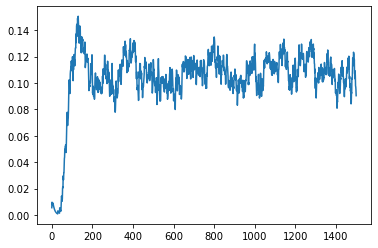

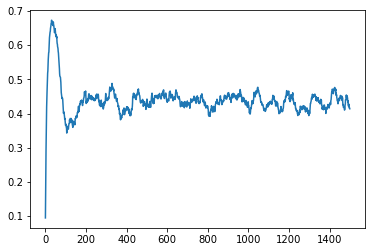

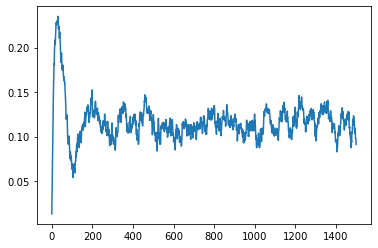

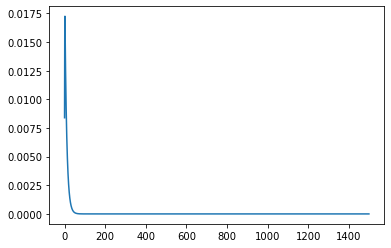

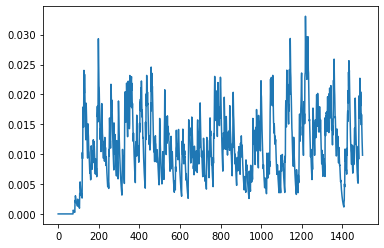

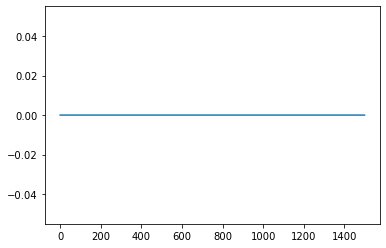

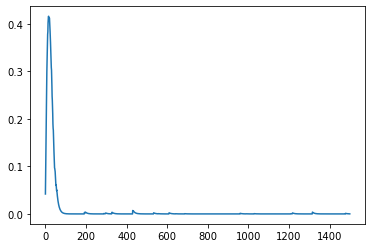

In [12]:
for i in range(10):
    fig, ax = plt.subplots()
    plt.plot(range(len(activations[:,i])), activations[:,i])
    plt.show()

# Count the number of neurons that are never activated through training

In [13]:
def count_silent(G,activations):
    count=0
    for idx, node in enumerate(G.nodes()):
        if np.mean(activations[:,node]) == 0:
            count+=1
    return count

def slient_evo():
    # How the number of silent neurons change as the weights are trained
    net_weight_history = weight_history['trained weights']
    silent=[]
    for mat in net_weight_history:
        weights = np.array(mat)
        weight_matrix = tf.Variable(weights)
        network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, 
                      time_constant = time_constant, timestep = timestep, 
                      activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)
        outputs, activations = network.simulate(time, inputs, input_weight_matrix)
        
        num_nodes = 256
        G = nx.complete_graph(num_nodes)
        activations = [activation.numpy() for activation in activations]
        activations = np.asarray(activations)

        silent.append(count_silent(G,activations))
    return silent

In [14]:
silent_neurons=slient_evo()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1118.22it/s]


In [ ]:
fig, ax = plt.subplots()
plt.plot(range(0,10*len(silent_neurons),10), silent_neurons)
plt.annotate(str(silent_neurons[-1]), (len(silent_neurons),silent_neurons[-1]))
plt.title('Evolution of silent neurons')
plt.xlabel('Training Iteration')
plt.ylabel('Number of silent neurons')
plt.show()

## Calculate the integral of neuron activations

In [16]:
def integrate_activations(activations):
    inte=[]
    for i in range(activations.shape[1]):
        inte.append(np.trapz(activations[:,i],dx=0.0001))
    return inte

def remove_silent():
    # Remove all the silent neurons before plotting histogram
    re_inte=[]
    for num in inte:
        if num!=0:
            re_inte.append(num)
    return re_inte

In [17]:
def draw_hist(data_list,interval):
    """
    生成data_list的直方图，统计的区间间隔为interval
    :param data_list: 数据列表
    :param interval: 固定间隔
    :return:
    """
    fig, ax = plt.subplots()
    plt.title('Distribution of neuron activation integrals')
    plt.xlabel('Integral of avtivation curve')
    plt.ylabel('Number of neurons')
    # 取值范围  为了在5，10这种整倍数时显示更好看
#     x = range(0,x_range, interval)
#     x = range(int(min(data_list) / interval) * interval, math.ceil(max(data_list) / interval) * interval, interval)
    hist = ax.hist(data_list,  edgecolor="black")
    for i in range(len(hist[0])):
        #  xy 即为在图上的坐标  text 为内容
        plt.annotate(text=int(hist[0][i]), xy=(hist[1][i] + interval / 3, hist[0][i]))

    plt.show()

In [18]:
inte=integrate_activations(activations)
re_inte=remove_silent()

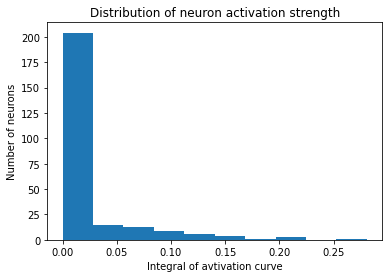

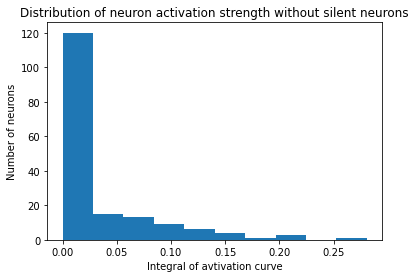

In [19]:
hist=plt.hist(inte)
plt.xlabel('Integral of avtivation curve')
plt.ylabel('Number of neurons')
plt.title('Distribution of neuron activation strength')
plt.show()

plt.hist(re_inte)
plt.xlabel('Integral of avtivation curve')
plt.ylabel('Number of neurons')
plt.title('Distribution of neuron activation strength without silent neurons')
plt.show()

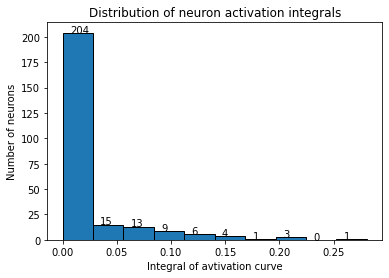

In [20]:
draw_hist(inte,0.02)

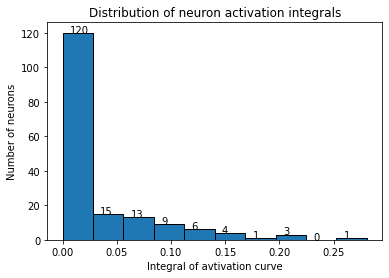

In [21]:
draw_hist(re_inte, 0.02)

# Losses

Text(0, 0.5, 'Losses')

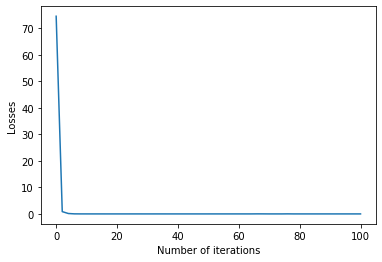

In [22]:
plt.plot(range(0,len(loss_history)*2,2),loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Losses')

# Singular Values

In [23]:
net_weight_history = weight_history['trained weights']
num_singular_values = 10
values = []
variance_prop = []
for mat in tqdm(net_weight_history):
    u, s, vh = np.linalg.svd(mat)
    values.append(s[:num_singular_values])
    tot_variance = np.dot(s,s)
    variance_prop.append([val**2/tot_variance for val in s])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:03<00:00, 15.17it/s]


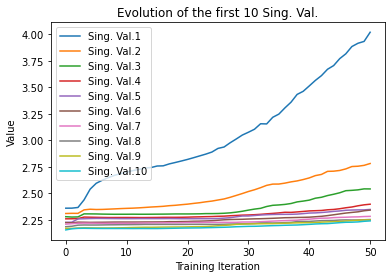

In [24]:
#The i'th column is the evolution of the i'th singular value
values = np.asarray(values)
num_total_iters = values[:, 0].shape[0]
fig, ax = plt.subplots()
    
for i in range(num_singular_values):
    plt.plot(range(num_total_iters), values[:, i], label='Sing. Val.'+str(i+1))
    plt.title('Evolution of the first 10 Sing. Val.')
    plt.xlabel('Training Iteration')
    plt.ylabel('Value')
    plt.legend()
#     plt.show()
# How to select the number of iterations? The singular values are not converging, and fluctuate heavily as the number increases.

# Eigenvalues

## Sort by and plot the real part.

In [25]:
num_eigen_values = 10
values_e = []

for mat in tqdm(net_weight_history):
    u, s = eig(mat)
    values_e.append(np.sort_complex(u[:num_singular_values]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:07<00:00,  6.87it/s]


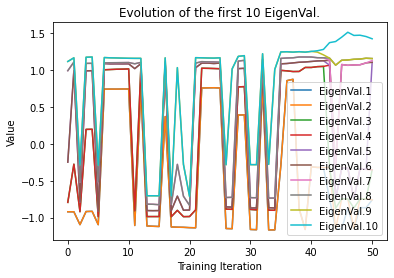

In [26]:
#The i'th column is the evolution of the i'th singular value
values_e = np.asarray(values_e)
num_total_iters = values_e[:, 0].shape[0]
fig, ax = plt.subplots()
    
for i in range(num_eigen_values):
    plt.plot(range(num_total_iters), values_e[:, i].real, label='EigenVal.'+str(i+1))
    plt.title('Evolution of the first 10 EigenVal.')
    plt.xlabel('Training Iteration')
    plt.ylabel('Value')
    plt.legend()
#     plt.show()

## Sort by and plot the mode.

In [27]:
num_eigen_values = 10
values_e = []

for mat in tqdm(net_weight_history):
    u, s = eig(mat)
    values_e.append(np.sort(abs(u[:num_singular_values])))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:07<00:00,  6.43it/s]


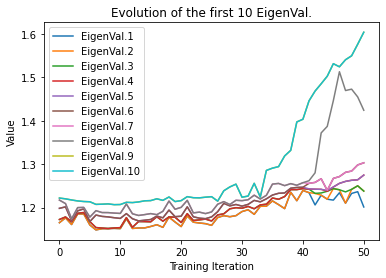

In [28]:
#The i'th column is the evolution of the i'th singular value
values_e = np.asarray(values_e)
num_total_iters = values_e[:, 0].shape[0]
fig, ax = plt.subplots()
    
for i in range(num_eigen_values):
    plt.plot(range(num_total_iters), values_e[:, i].real, label='EigenVal.'+str(i+1))
    plt.title('Evolution of the first 10 EigenVal.')
    plt.xlabel('Training Iteration')
    plt.ylabel('Value')
    plt.legend()
#     plt.show()

# PCA

In [29]:
pca = PCA(n_components=3)

In [30]:
activations1=pd.DataFrame(activations1)
activations2=pd.DataFrame(activations2)
activations=activations1.append(activations2)

In [31]:
pca.fit(activations)

PCA(n_components=3)

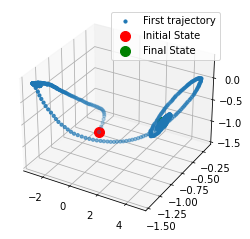

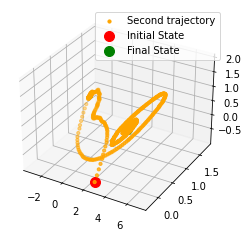

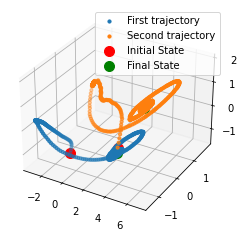

In [32]:
activations=pd.DataFrame(activations)
# Store results of PCA in a data frame
result=pd.DataFrame(pca.transform(activations), columns=['PCA%i' % i for i in range(3)], index=activations.index)
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result['PCA0'][0:1500], result['PCA1'][0:1500], result['PCA2'][0:1500], label='First trajectory', s=10)
ax.scatter( result['PCA0'][0:1], result['PCA1'][0:1],result['PCA2'][0:1], cmap="Set2_r", c='red' ,s=100, label='Initial State')
ax.scatter(result['PCA0'][1499:1500], result['PCA1'][1499:1500],result['PCA2'][1499:1500],  cmap="Set2_r",c='green', s=100, label='Final State')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'][1500:], result['PCA1'][1500:], result['PCA2'][1500:], s=10,c='orange',label='Second trajectory')
ax.scatter( result['PCA0'][1500:1501], result['PCA1'][1500:1501],result['PCA2'][1500:1501], cmap="Set2_r" ,c='red',s=100,label='Initial State')
ax.scatter( result['PCA0'][2999:3000], result['PCA1'][2999:3000],result['PCA2'][2999:3000], cmap="Set2_r",c='green', s=100,label='Final State')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'][0:1500], result['PCA1'][0:1500], result['PCA2'][0:1500], label='First trajectory', s=10)
ax.scatter( result['PCA0'][0:1], result['PCA1'][0:1],result['PCA2'][0:1], cmap="Set2_r", c='red' ,s=100)
ax.scatter(result['PCA0'][1499:1500], result['PCA1'][1499:1500],result['PCA2'][1499:1500],  cmap="Set2_r",c='green', s=100)
ax.scatter(result['PCA0'][1500:], result['PCA1'][1500:], result['PCA2'][1500:], s=10,label='Second trajectory')
ax.scatter( result['PCA0'][1500:1501], result['PCA1'][1500:1501],result['PCA2'][1500:1501], cmap="Set2_r" ,c='red',s=100,label='Initial State')
ax.scatter( result['PCA0'][2999:3000], result['PCA1'][2999:3000],result['PCA2'][2999:3000], cmap="Set2_r",c='green', s=100,label='Final State')
plt.legend()
plt.show()

# Slow Points

In [35]:
with open("slow_points.txt", "rb") as fp:   # Unpickling
    slow_points = pickle.load(fp)

with open("J_eig.txt", "rb") as fp:   # Unpickling
    J_eig = pickle.load(fp)

In [36]:
ac_slow=activations.append(slow_points)

In [37]:
pca2=PCA(n_components=3)

In [38]:
pca2.fit(ac_slow)

PCA(n_components=3)

In [39]:
for i, slow_point in enumerate(slow_points):
    if np.all(J_eig[i][0] < 0):
        sp_type = 'fixed'
        print('fixed:',i)
    else:
        sp_type = 'saddle'
        print('saddle:',j)
marker = {'fixed': 'X', 'saddle': '1'}
# ax.scatter(slow_point[0], slow_point[1], marker=marker[sp_type])

fixed: 0
fixed: 1
fixed: 2
fixed: 3
fixed: 4
fixed: 5


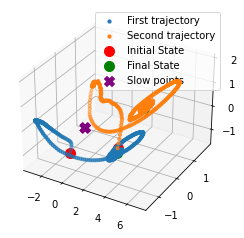

In [40]:
result=pd.DataFrame(pca2.transform(ac_slow), columns=['PCA%i' % i for i in range(3)], index=ac_slow.index)
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'][0:1500], result['PCA1'][0:1500], result['PCA2'][0:1500], label='First trajectory', s=10)
ax.scatter( result['PCA0'][0:1], result['PCA1'][0:1],result['PCA2'][0:1], cmap="Set2_r", c='red' ,s=100)
ax.scatter(result['PCA0'][1499:1500], result['PCA1'][1499:1500],result['PCA2'][1499:1500],  cmap="Set2_r",c='green', s=100)
ax.scatter(result['PCA0'][1500:3000], result['PCA1'][1500:3000], result['PCA2'][1500:3000], s=10,label='Second trajectory')
ax.scatter( result['PCA0'][1500:1501], result['PCA1'][1500:1501],result['PCA2'][1500:1501], cmap="Set2_r" ,c='red',s=100,label='Initial State')
ax.scatter( result['PCA0'][2999:3000], result['PCA1'][2999:3000],result['PCA2'][2999:3000], cmap="Set2_r",c='green', s=100,label='Final State')
ax.scatter( result['PCA2'][3000:],result['PCA0'][3000:], result['PCA1'][3000:],cmap="Set2_r", s=100,c='purple',
           marker=marker[sp_type],label='Slow points')
# ax.scatter( result['PCA2'][1501:1502],result['PCA0'][1501:1502], result['PCA1'][1501:1502],cmap="Set2_r", s=100, marker='X')
plt.legend()